# EDA and preprocessing

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

DATA_PATH = "./data"
sections = ['environment', 'business', 'film', 'culture', 'education']

In [177]:
dfs = [pd.read_csv(f"{DATA_PATH}/{section}_news.csv") for section in sections]
df = pd.concat(dfs)

## Exploratory data analysis

In [178]:
df = df.reset_index(drop=True)
df

,Content,Section
0,A Victorian woman is facing almost 300 animal...,environment
1,Fish populations will continue to be over-expl...,environment
2,The Covid-19 vaccinations captured the world’s...,environment
3,New international rules to tackle the “wild we...,environment
4,The mother of Ella Kissi-Debrah has called on ...,environment
...,...,...
2749,More than 250 former pupils at Westminster Sch...,education
2750,"The chief inspector of schools, Amanda Spielma...",education
2751,Teaching unions and school leaders are to hold...,education
2752,Schools will prioritise pupils’ emotional and ...,education


In [179]:
df.describe()

,Content,Section
count,2754,2754
unique,2711,5
top,In the first episode of Netflix’s latest hit s...,film
freq,2,599


In [180]:
df[df.duplicated(keep=False)].sort_values(by=['Content']).head(10)

,Content,Section
2160,A question is posed in the group show Poet Sla...,culture
1988,A question is posed in the group show Poet Sla...,culture
2026,A stoush has erupted between the publisher of ...,culture
2180,A stoush has erupted between the publisher of ...,culture
2008,"Alicia Keys, I have a bone to pick with you. F...",culture
2136,"Alicia Keys, I have a bone to pick with you. F...",culture
2134,Aspiring film-makers take note: a love triangl...,culture
1999,Aspiring film-makers take note: a love triangl...,culture
2009,At the beginning of the pandemic Mae Martin’s ...,culture
2127,At the beginning of the pandemic Mae Martin’s ...,culture


In [181]:
df[df.duplicated()]['Section'].unique()

array(['culture'], dtype=object)

In [182]:
df.drop_duplicates(inplace=True)
df.shape

(2711, 2)

The classes are roughly balanced, which implies our classification task is somewhat of simpler interpretation. Nonetheless we will use more thorough performance metrics than just accuracy.

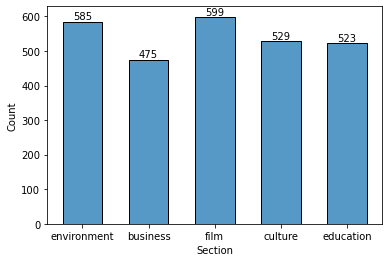

In [183]:
plt.figure()
ax = sns.histplot(data=df['Section'], shrink=.6)
ax.bar_label(ax.containers[0]);

Let's inspect the distribution of article lengths, both overall and per class. Knowing distributional information would be paramount when e.g. using article length as a DV in a regression model. But we won't do that here. However, although we won't be directly using it as an IV, information about article length (per class) could trickle down to our features and thus raise concerns about class balance (i.e. we are not interested here in a model which predicts class from article length, but rather learns from text). Luckily, the boxplot shows that length is not too unbalanced across classes. In addition, methods such as TF-IDF transformation automatically normalise the feature vectors prior to training.

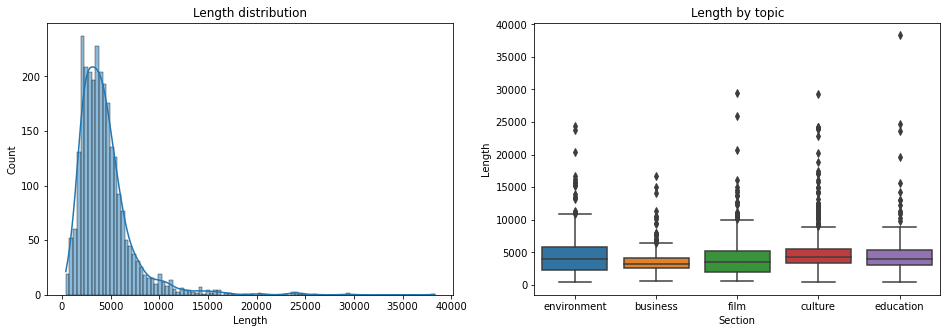

In [184]:
df['Length'] = df['Content'].str.len()

fig, axs = plt.subplots(1, 2, figsize=(16,5));
sns.histplot(df['Length'], kde=True, ax=axs[0]).set_title("Length distribution");
sns.boxplot(x=df['Section'], y=df['Length'], ax=axs[1]).set_title("Length by topic");

## Preprocessing text data

In [212]:
df.iloc[0,0]

' A Victorian woman is facing almost 300 animal cruelty charges after wildlife officers allegedly found the carcasses of 140 protected native birds, including 128 wedge-tailed eagles, at her property. The office of the conservation regulator said police, wildlife officers, and officials from the agriculture department searched the woman’s property in Violet Town in August after a number of dead wedge-tailed eagles were found in the area. She has been charged with 291 breaches of the Wildlife Act 1975 and the Prevention of Cruelty to Animals Act 1986, including offences relating to poisoning the birds of prey. The maximum penalty for killing native birds or being in possession of them without a licence carries hefty fines or penalties of up to two years in jail. The woman will face court in Benalla next year. The chief conservation regulator, Kate Gavens, said her office took matters like this “very seriously”. “Wedge-tailed eagles are Victoria’s largest bird of prey and an important pa

In [213]:
df['Content_1'] = df['Content'].str.lower()
df['Content_1'] = df['Content_1'].str.strip()
df.head()

,Content,Section,Length,Content_1
0,A Victorian woman is facing almost 300 animal...,environment,1593,a victorian woman is facing almost 300 animal ...
1,Fish populations will continue to be over-expl...,environment,4199,fish populations will continue to be over-expl...
2,The Covid-19 vaccinations captured the world’s...,environment,23818,the covid-19 vaccinations captured the world’s...
3,New international rules to tackle the “wild we...,environment,5458,new international rules to tackle the “wild we...
4,The mother of Ella Kissi-Debrah has called on ...,environment,3198,the mother of ella kissi-debrah has called on ...


In [205]:
nlp = spacy.load("en_core_web_sm")
nlp

### Write text processing function on single article

Let us remove numbers, stop words, punctuation and lemmatise. Let us see the pipeline on a single news article.

In [237]:
txt0 = df.loc[0,'Content_1']
txt0

'a victorian woman is facing almost 300 animal cruelty charges after wildlife officers allegedly found the carcasses of 140 protected native birds, including 128 wedge-tailed eagles, at her property. the office of the conservation regulator said police, wildlife officers, and officials from the agriculture department searched the woman’s property in violet town in august after a number of dead wedge-tailed eagles were found in the area. she has been charged with 291 breaches of the wildlife act 1975 and the prevention of cruelty to animals act 1986, including offences relating to poisoning the birds of prey. the maximum penalty for killing native birds or being in possession of them without a licence carries hefty fines or penalties of up to two years in jail. the woman will face court in benalla next year. the chief conservation regulator, kate gavens, said her office took matters like this “very seriously”. “wedge-tailed eagles are victoria’s largest bird of prey and an important par

We can let Spacy do all the magic by simply calling its English model on our text.

In [215]:
doc = nlp(txt0)

The resulting Doc object contains all sorts of useful information for us to exploit, such as a dependency structure, recognised named entities, part-of-speech (POS) tags, etc. In addition, spacy has already performed tokenisation for us; we can access some of the attributes of each token as follows:

In [216]:
def extract_features(doc):
    return [(tkn.text, tkn.is_stop, tkn.is_punct, tkn.lemma_, tkn.is_alpha) for tkn in doc]

pd.DataFrame(data=extract_features(doc), columns=['text','is_stop','is_punct','lemma','is_alpha'])

,text,is_stop,is_punct,lemma,is_alpha
0,a,True,False,a,True
1,victorian,False,False,victorian,True
2,woman,False,False,woman,True
3,is,True,False,be,True
4,facing,False,False,face,True
...,...,...,...,...,...
288,on,True,False,on,True
289,1800,False,False,1800,False
290,333,False,False,333,False
291,000,False,False,000,False


In [217]:
# nlp.Defaults.stop_words
# nlp.Defaults.stop_words |= {"my_new_stopword1","my_new_stopword2"}
# nlp.Defaults.stop_words -= {"my_old_stopword1","my_old_stopword2"}

We can write a simple function to take care of the cleaning for us.

In [220]:
def keep_token(t):
    """Decide whether to keep a token"""
    return (t.is_alpha and not (t.is_space or t.is_punct or t.is_stop))

def lemmatised_string(doc):
    """Lemmatise remaining tokens"""
    return " ".join(t.lemma_ for t in doc if keep_token(t))

txt0_cleaned = lemmatised_string(doc)
txt0_cleaned

'victorian woman face animal cruelty charge wildlife officer allegedly find carcass protect native bird include wedge tail eagle property office conservation regulator say police wildlife officer official agriculture department search woman property violet town august number dead wedge tail eagle find area charge breach wildlife act prevention cruelty animal act include offence relate poison bird prey maximum penalty kill native bird possession licence carry hefty fine penalty year jail woman face court benalla year chief conservation regulator kate gavens say office take matter like seriously wedge tail eagle victoria large bird prey important environment gavens say investigation show conservation regulator commitment combat wildlife crime protect iconic wedge tail eagle wedge tail eagle see pest farmer concern prey lamb department environment land water planning say bird rarely healthy lamb grown sheep wildlife expert say kill resident pair create territorial vacuum encourage bird co

### Apply to all articles

We

In [219]:
docs = list(nlp.pipe(df['Content_1']))  # explain nlp.pipe

In [221]:
df['Content_parsed'] = [lemmatised_string(doc) for doc in docs]

In [228]:
pre_spacy = df.loc[0,'Content_1']
pre_spacy

'a victorian woman is facing almost 300 animal cruelty charges after wildlife officers allegedly found the carcasses of 140 protected native birds, including 128 wedge-tailed eagles, at her property. the office of the conservation regulator said police, wildlife officers, and officials from the agriculture department searched the woman’s property in violet town in august after a number of dead wedge-tailed eagles were found in the area. she has been charged with 291 breaches of the wildlife act 1975 and the prevention of cruelty to animals act 1986, including offences relating to poisoning the birds of prey. the maximum penalty for killing native birds or being in possession of them without a licence carries hefty fines or penalties of up to two years in jail. the woman will face court in benalla next year. the chief conservation regulator, kate gavens, said her office took matters like this “very seriously”. “wedge-tailed eagles are victoria’s largest bird of prey and an important par

In [229]:
post_spacy = df.loc[0,'Content_parsed']
post_spacy

'victorian woman face animal cruelty charge wildlife officer allegedly find carcass protect native bird include wedge tail eagle property office conservation regulator say police wildlife officer official agriculture department search woman property violet town august number dead wedge tail eagle find area charge breach wildlife act prevention cruelty animal act include offence relate poison bird prey maximum penalty kill native bird possession licence carry hefty fine penalty year jail woman face court benalla year chief conservation regulator kate gavens say office take matter like seriously wedge tail eagle victoria large bird prey important environment gavens say investigation show conservation regulator commitment combat wildlife crime protect iconic wedge tail eagle wedge tail eagle see pest farmer concern prey lamb department environment land water planning say bird rarely healthy lamb grown sheep wildlife expert say kill resident pair create territorial vacuum encourage bird co

In [231]:
print(f"We went from {len(pre_spacy)} to {len(post_spacy)} tokens for this article.")

We went from 1592 to 1044 tokens for this article.


## Train-test split

## Numericalisation

Spacy automatically computes word embedding vectors for each token, but we will instead create TF-IDF vectors for our classifier.